# 01.2c: Shell vs. Blob Test (Causal Space)

**Goal:** Same analysis as 01.2b, but in causal space instead of gamma space.

In 01.2b, we found that the token cloud in **gamma space** is a high-dimensional Gaussian blob centered at the origin. Projections in any direction showed Gaussians with std ≈ 0.02, but the radial distribution clustered around 1.07 gamma units due to the curse of dimensionality.

Now we transform to **causal space** and ask: does the structure change?

The causal transform stretches space according to the eigenvalues of the metric tensor, normalizing variance across dimensions. This might reveal different geometry.

## Mathematical Background

The transformation to causal coordinates:

$$\mathbf{z} = \sqrt{\Lambda} \, Q^T \gamma'$$

where:
- **Q** = eigenvectors of the causal metric M (2,560 × 2,560)
- **Λ** = diagonal matrix of eigenvalues (2,560 values)
- **γ'** = centered token vectors (151,936 × 2,560)

In causal space, distances are measured in **logometers** (log-probability units) and the metric becomes the identity matrix.

We'll project onto random unit vectors **u** in causal space:

$$p_i = \mathbf{z}_i \cdot \mathbf{u}$$

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
RANDOM_SEED = 42
COLORMAP = 'inferno'

NUM_RANDOM_DIRECTIONS = 6  # Test this many random directions
NUM_BINS = 100  # Histogram bins

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

# Set random seed
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
# Load centered gamma
gamma_centered_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_centered = load_file(gamma_centered_path)['gamma_centered']

# Load eigenvectors Q
Q_path = Path(TENSOR_DIR) / "causal_eigenvectors_Q.safetensors"
Q = load_file(Q_path)['Q']

# Load eigenvalues Λ
Lambda_path = Path(TENSOR_DIR) / "causal_eigenvalues_Lambda.safetensors"
Lambda = load_file(Lambda_path)['Lambda']

N, d = gamma_centered.shape

print(f"Loaded data:")
print(f"  γ' shape: {gamma_centered.shape}")
print(f"  Q shape: {Q.shape}")
print(f"  Λ shape: {Lambda.shape}")

Loaded data:
  γ' shape: torch.Size([151936, 2560])
  Q shape: torch.Size([2560, 2560])
  Λ shape: torch.Size([2560])


## Step 2: Transform to Causal Space

In [4]:
# Transform: z = sqrt(Λ) Q^T γ'
print("Transforming to causal space...")
print("This will take a moment (matrix multiply with 151,936 × 2,560)\n")

# Step 1: Rotate to eigenbasis: Q^T γ'
gamma_rotated = gamma_centered @ Q  # (N, d) @ (d, d) = (N, d)

# Step 2: Scale by sqrt(eigenvalues): sqrt(Λ) * (Q^T γ')
sqrt_Lambda = torch.sqrt(Lambda)  # (d,)
z = gamma_rotated * sqrt_Lambda  # Broadcasting: (N, d) * (d,) = (N, d)

print(f"Causal coordinates computed:")
print(f"  z shape: {z.shape}")
print(f"  z memory: {z.element_size() * z.nelement() / 1024**2:.1f} MB")

Transforming to causal space...
This will take a moment (matrix multiply with 151,936 × 2,560)

Causal coordinates computed:
  z shape: torch.Size([151936, 2560])
  z memory: 1483.8 MB


## Step 3: Quick Sanity Check

In [5]:
# Check mean (should be near zero)
z_mean = z.mean(dim=0)
z_mean_norm = z_mean.norm().item()

print(f"Mean of causal coordinates:")
print(f"  Norm: {z_mean_norm:.2e} logometers")
print(f"  Should be very close to zero.\n")

# Check norms
z_norms = z.norm(dim=1)
print(f"Causal norms statistics:")
print(f"  Mean: {z_norms.mean().item():.4f} logometers")
print(f"  Std: {z_norms.std().item():.4f} logometers")
print(f"  Min: {z_norms.min().item():.4f} logometers")
print(f"  Max: {z_norms.max().item():.4f} logometers")

Mean of causal coordinates:
  Norm: 1.86e-06 logometers
  Should be very close to zero.

Causal norms statistics:
  Mean: 49.6121 logometers
  Std: 9.5816 logometers
  Min: 4.4591 logometers
  Max: 87.8214 logometers


## Step 4: Generate Random Unit Directions in Causal Space

In [6]:
# Generate random unit vectors in causal space
random_directions = torch.randn(NUM_RANDOM_DIRECTIONS, d)
random_directions = random_directions / random_directions.norm(dim=1, keepdim=True)

print(f"Generated {NUM_RANDOM_DIRECTIONS} random unit directions in causal space")
print(f"\nVerifying they're unit vectors:")
for i, direction in enumerate(random_directions):
    print(f"  Direction {i}: norm = {direction.norm().item():.6f}")

Generated 6 random unit directions in causal space

Verifying they're unit vectors:
  Direction 0: norm = 1.000000
  Direction 1: norm = 1.000000
  Direction 2: norm = 1.000000
  Direction 3: norm = 1.000000
  Direction 4: norm = 1.000000
  Direction 5: norm = 1.000000


## Step 5: Project Tokens onto Each Direction

In [7]:
# Project all tokens onto all directions at once
# Shape: (N, NUM_RANDOM_DIRECTIONS)
projections = z @ random_directions.T

print(f"Computed projections in causal space:")
print(f"  Shape: {projections.shape}")
print(f"  (Each column is one direction, each row is one token)")

Computed projections in causal space:
  Shape: torch.Size([151936, 6])
  (Each column is one direction, each row is one token)


## Step 6: Plot Signed Histograms for Each Direction

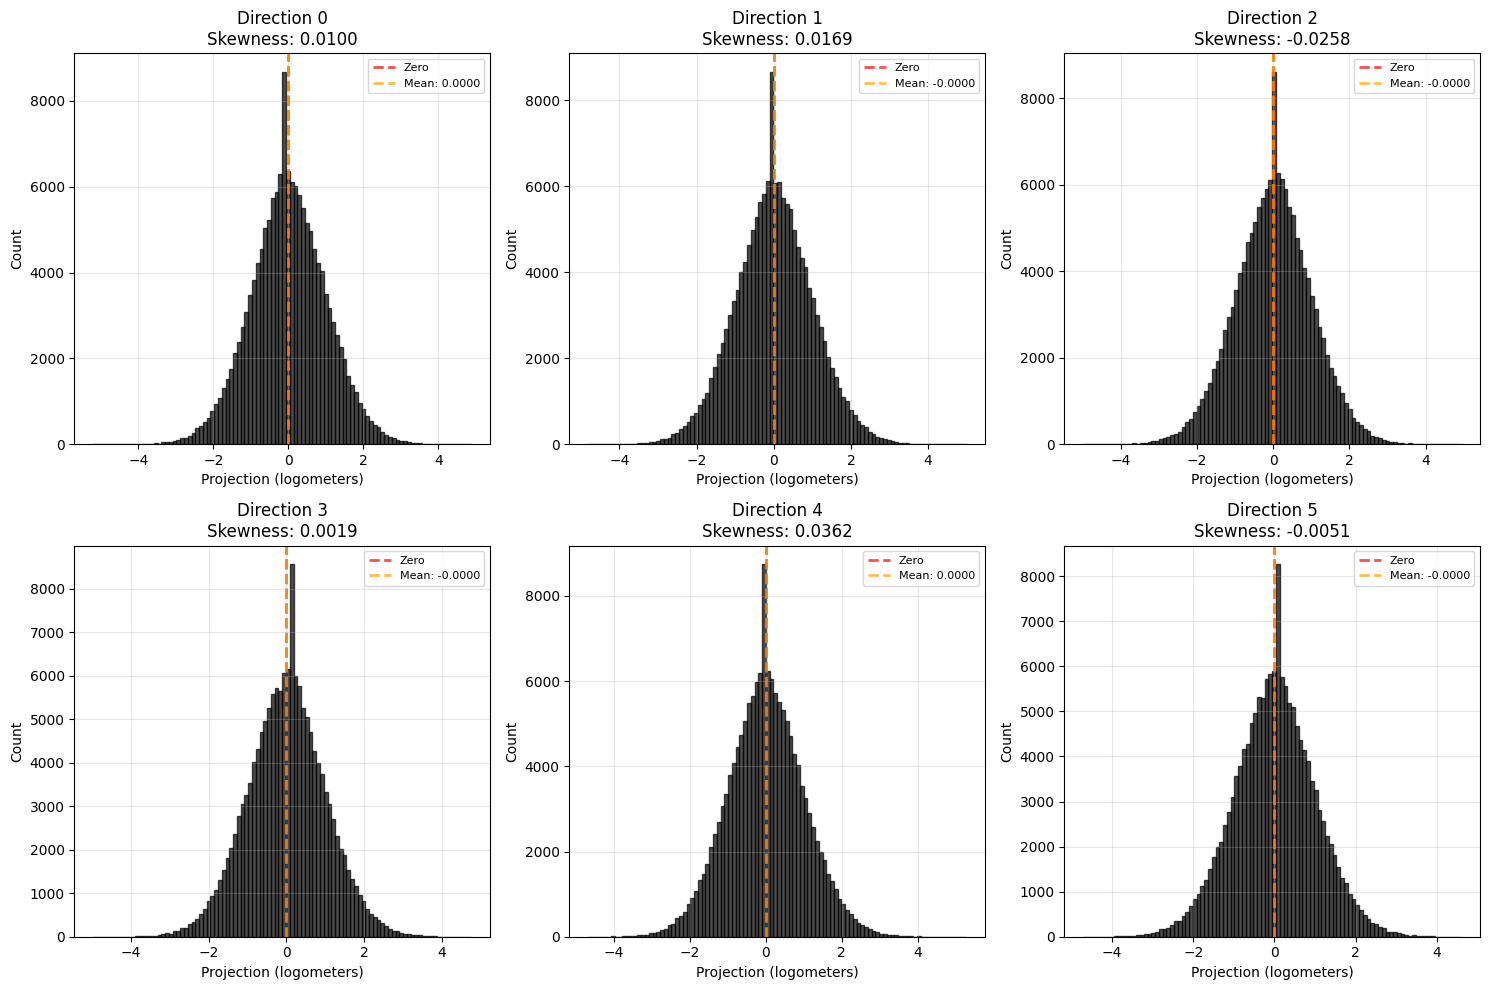


Interpretation:
- If shell: All histograms should be symmetric around zero (skewness ≈ 0)
- If offset blob: At least one direction shows strong asymmetry (skewness >> 0 or << 0)

Compare to 01.2b (gamma space) to see how the causal transform changes the structure.


In [8]:
# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=100)
axes = axes.flatten()

for i in range(NUM_RANDOM_DIRECTIONS):
    ax = axes[i]
    proj = projections[:, i].cpu().numpy()
    
    # Plot histogram
    ax.hist(proj, bins=NUM_BINS, color='black', alpha=0.7, edgecolor='black')
    
    # Add vertical line at zero
    ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Zero')
    
    # Add mean line
    mean_proj = proj.mean()
    ax.axvline(mean_proj, color='orange', linestyle='--', linewidth=2, alpha=0.7, 
               label=f'Mean: {mean_proj:.4f}')
    
    # Statistics
    std_proj = proj.std()
    skewness = ((proj - mean_proj) ** 3).mean() / (std_proj ** 3)
    
    ax.set_xlabel('Projection (logometers)')
    ax.set_ylabel('Count')
    ax.set_title(f'Direction {i}\nSkewness: {skewness:.4f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- If shell: All histograms should be symmetric around zero (skewness ≈ 0)")
print("- If offset blob: At least one direction shows strong asymmetry (skewness >> 0 or << 0)")
print("\nCompare to 01.2b (gamma space) to see how the causal transform changes the structure.")

## Step 7: Quantitative Analysis

In [9]:
# Compute statistics for each direction
print("Projection statistics for each random direction (in causal space):\n")
print(f"{'Dir':<5} {'Mean':<10} {'Std':<10} {'Skewness':<12} {'Min':<10} {'Max':<10}")
print("-" * 60)

for i in range(NUM_RANDOM_DIRECTIONS):
    proj = projections[:, i]
    mean_proj = proj.mean().item()
    std_proj = proj.std().item()
    skewness = ((proj - mean_proj) ** 3).mean().item() / (std_proj ** 3)
    min_proj = proj.min().item()
    max_proj = proj.max().item()
    
    print(f"{i:<5} {mean_proj:<10.6f} {std_proj:<10.6f} {skewness:<12.6f} {min_proj:<10.4f} {max_proj:<10.4f}")

print("\nIf all skewness values are close to 0: Gaussian blob (centered).")
print("If any skewness is large (|skew| > 0.5): Evidence for offset blob or asymmetry.")

Projection statistics for each random direction (in causal space):

Dir   Mean       Std        Skewness     Min        Max       
------------------------------------------------------------
0     0.000000   0.998587   0.009994     -5.2002    4.8759    
1     -0.000000  0.998648   0.016872     -4.8040    4.9828    
2     -0.000000  0.998668   -0.025755    -4.9780    4.9262    
3     -0.000000  0.998685   0.001870     -4.9723    4.7584    
4     0.000000   0.998699   0.036189     -4.6657    5.2752    
5     -0.000000  0.998687   -0.005128    -4.7100    4.5982    

If all skewness values are close to 0: Gaussian blob (centered).
If any skewness is large (|skew| > 0.5): Evidence for offset blob or asymmetry.


## Step 8: Compare Gamma vs. Causal Spread

In [10]:
# Compute average std deviation in projections
causal_avg_std = projections.std(dim=0).mean().item()

print(f"Average standard deviation of projections:")
print(f"  Causal space: {causal_avg_std:.6f} logometers")
print(f"  Gamma space (from 01.2b): ~0.020688 gamma units")
print(f"\nRatio (causal/gamma): {causal_avg_std / 0.020688:.2f}")
print(f"\nThis tells us how much the causal metric 'stretches' the space.")

Average standard deviation of projections:
  Causal space: 0.998663 logometers
  Gamma space (from 01.2b): ~0.020688 gamma units

Ratio (causal/gamma): 48.27

This tells us how much the causal metric 'stretches' the space.


## Summary

We transformed the token cloud to causal space and repeated the shell-vs-blob test.

**Key questions:**
1. Are the projections still Gaussian and centered at zero?
2. How does the spread (std) compare to gamma space?
3. Does the causal transform reveal any asymmetry or structure that was hidden in gamma space?

The causal metric normalizes variance across dimensions, so if the gamma-space Gaussian was anisotropic (stretched in some directions), the causal transform should make it more isotropic.